# Possible multi TIC 52368076

Teff: 5154.0 K Logg: 4.47

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import astropy.units as u
from glob import glob

paths = glob('52368076/hlsp_*.fits')

files = [fits.getdata(path) for path in paths]

headers = [fits.getheader(path) for path in paths]

In [3]:
from scipy.stats import binned_statistic
import sys
sys.path.insert(0, '/Users/bmmorris/git/gravdark/')

from gravdark import LightCurve

In [4]:
lcs = [LightCurve(times=f['TIME'][~np.isnan(f["TIME"]) & ~np.isnan(f["PDCSAP_FLUX"]) & (f['PDCSAP_FLUX'] != 0)], 
                  fluxes=f['PDCSAP_FLUX'][~np.isnan(f["TIME"])& ~np.isnan(f["PDCSAP_FLUX"]) & (f['PDCSAP_FLUX'] != 0)], 
                  name=header['OBJECT']) for f, header in zip(files, headers)]

from gravdark import concatenate_light_curves

lc = concatenate_light_curves(lcs)

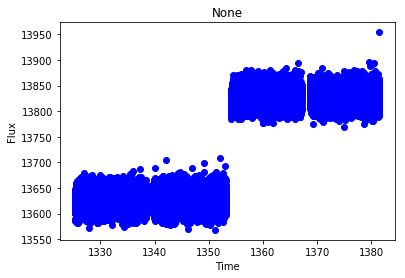

In [5]:
lc.plot()

In [6]:
from batman import TransitParams, TransitModel

In [7]:
paramsb = TransitParams()
paramsb.per = 4.653811
paramsb.t0 = 1327.432906
paramsb.duration = 4/24
paramsb.rp = 0.0292
paramsb.a  = 12.1
paramsb.u = [0.5971, 0.1172]
paramsb.limb_dark = 'quadratic'
paramsb.w = 90
paramsb.inc = 90
paramsb.ecc = 0

paramsc = TransitParams()
paramsc.per = 9.150607
paramsc.inc = 90
paramsc.t0 = 1334.45669
paramsc.duration = 4/24
paramsc.rp = 0.0291
paramsc.a = 23.39
paramsc.u = [0.5971, 0.1172]
paramsc.limb_dark = 'quadratic'
paramsc.w = 90
paramsc.ecc = 0

In [8]:
# Skip partial transits
transitsb = LightCurve(**lc.mask_out_of_transit(paramsb, oot_duration_fraction=2)
                      ).get_transit_light_curves(paramsb)[:-1]
transitsc = LightCurve(**lc.mask_out_of_transit(paramsc, oot_duration_fraction=2)
                      ).get_transit_light_curves(paramsc)[1:]

In [9]:
import emcee
from copy import deepcopy
from corner import corner
import celerite
from celerite import terms, modeling

Initial log likelihood: -2288.4660178888143


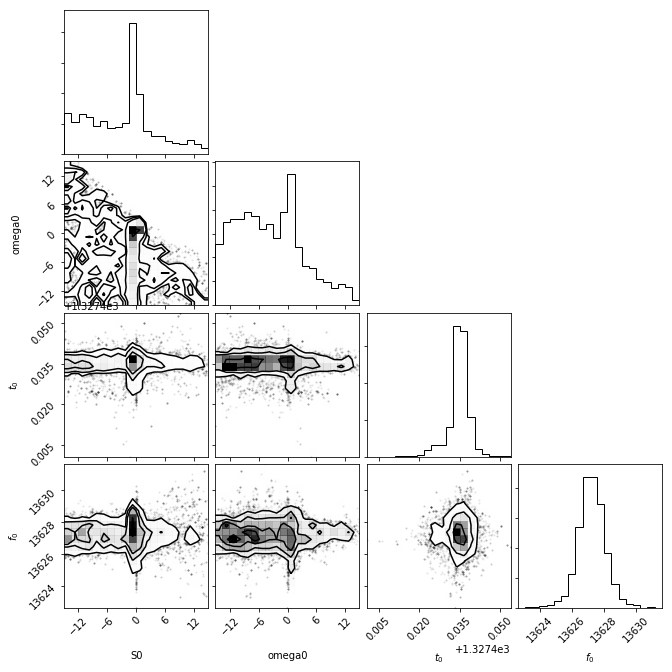

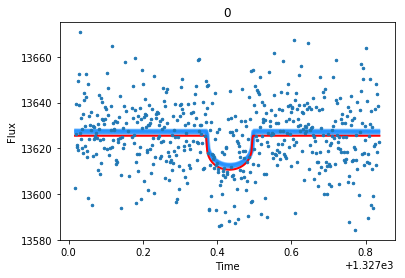

Initial log likelihood: -2309.7605432185146


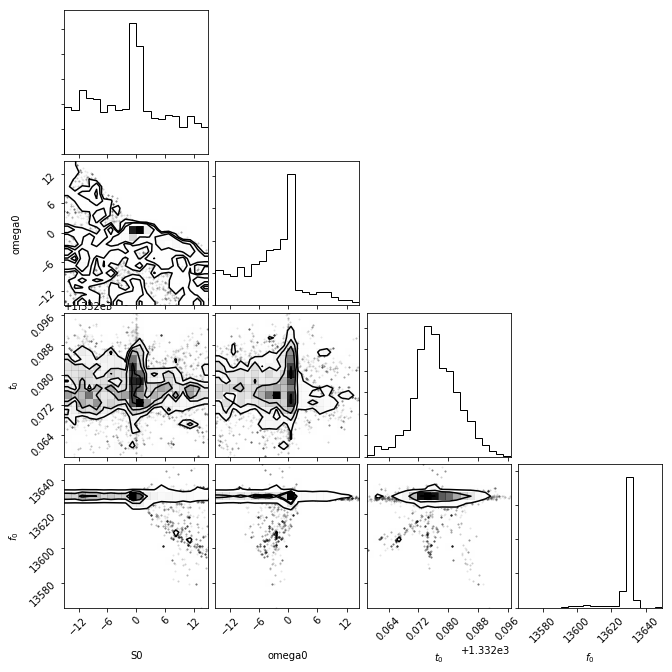

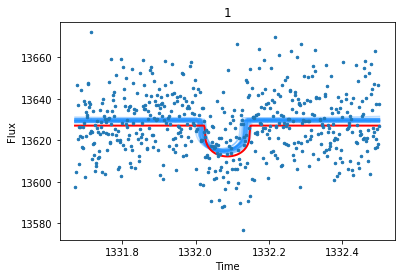

Initial log likelihood: -2447.8469514662997


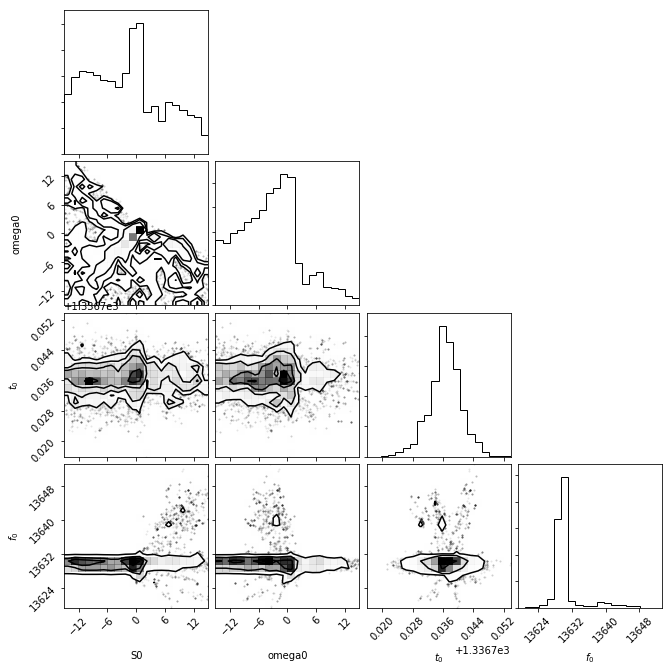

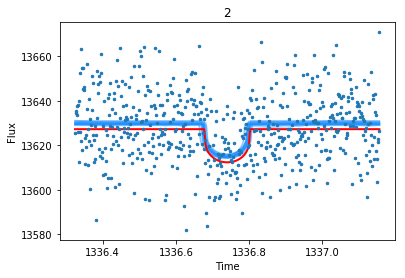

Initial log likelihood: -2429.54987135356


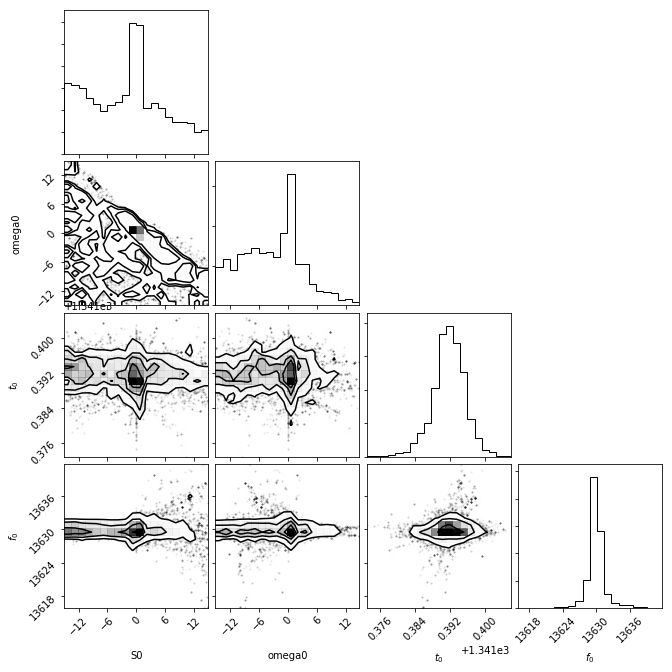

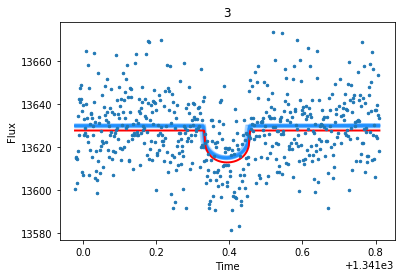

Initial log likelihood: -2488.1074314643224


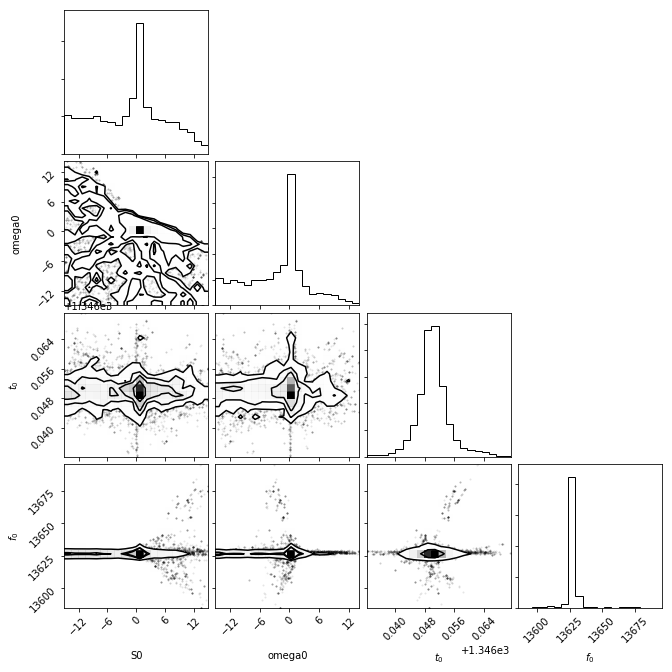

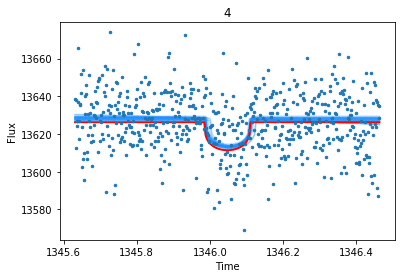

Initial log likelihood: -2481.196421505022


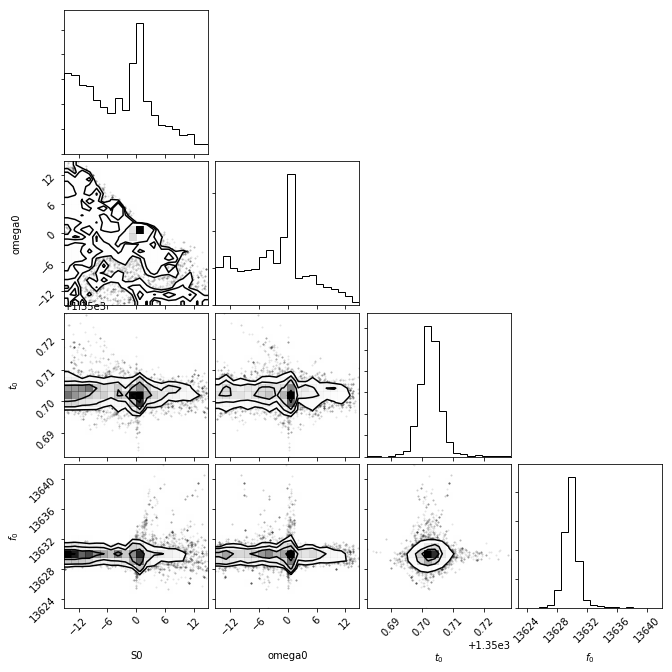

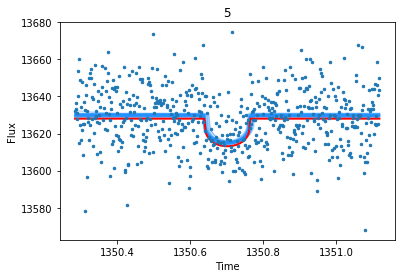

Initial log likelihood: -2414.672118182612


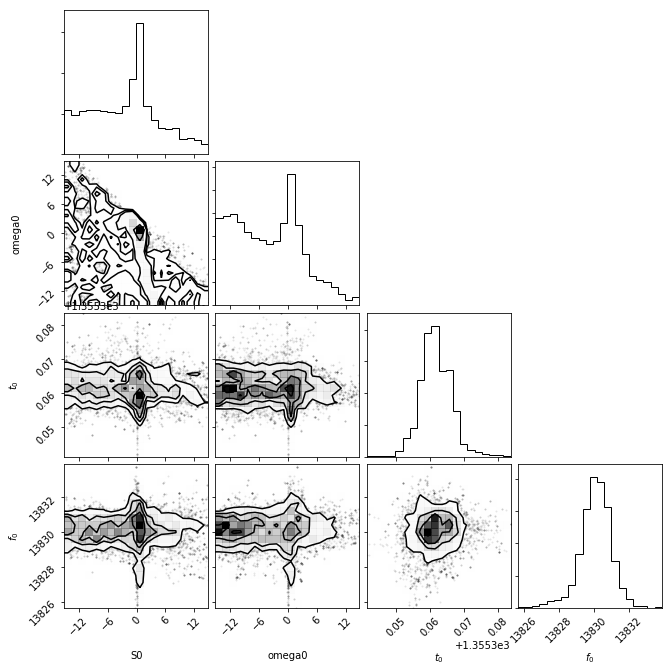

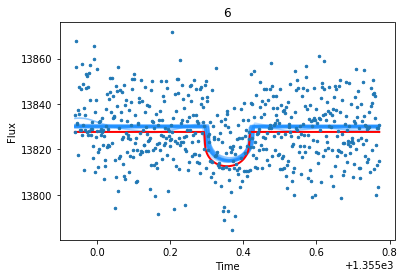

Initial log likelihood: -2466.6997756159503


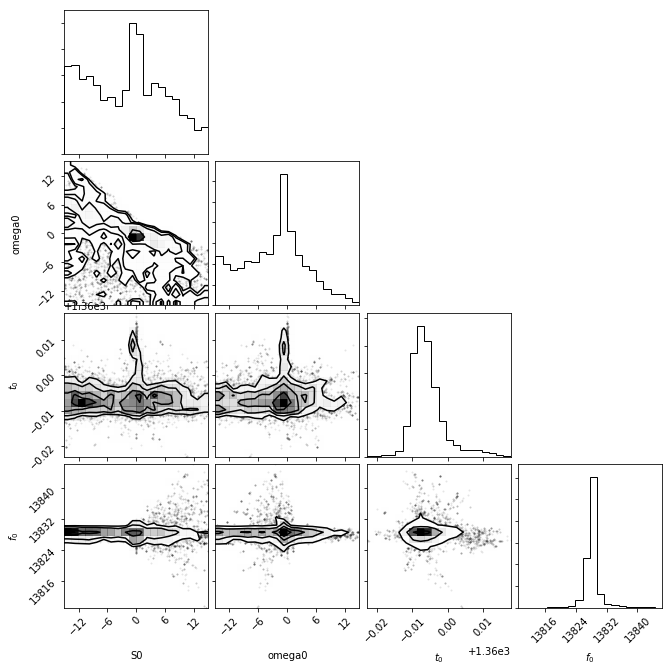

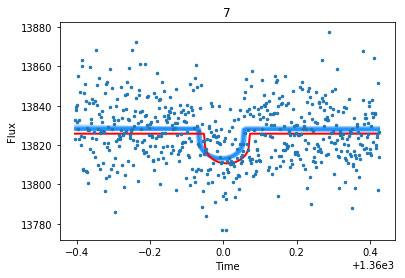

Initial log likelihood: -2435.119915681551


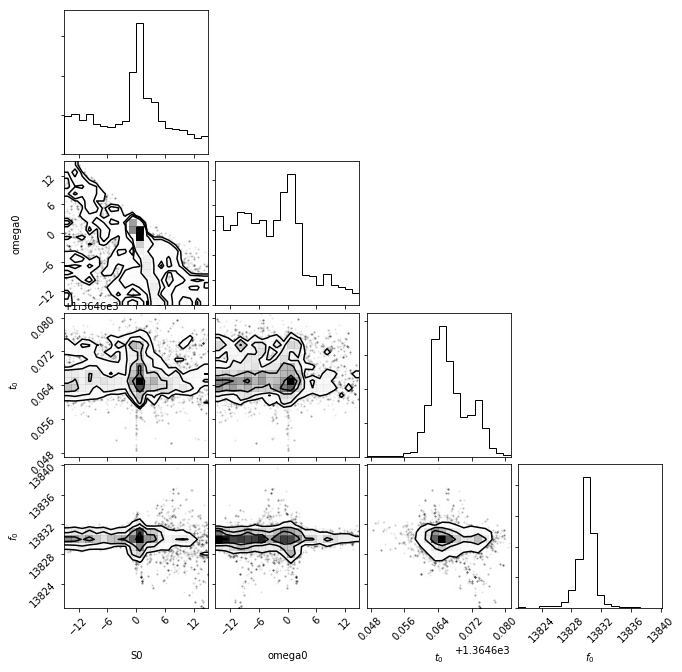

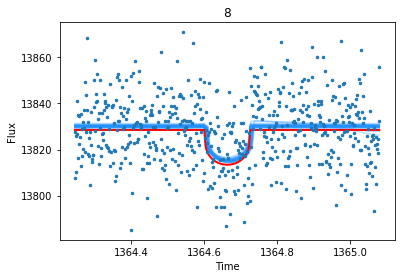

Initial log likelihood: -2434.4530177030183


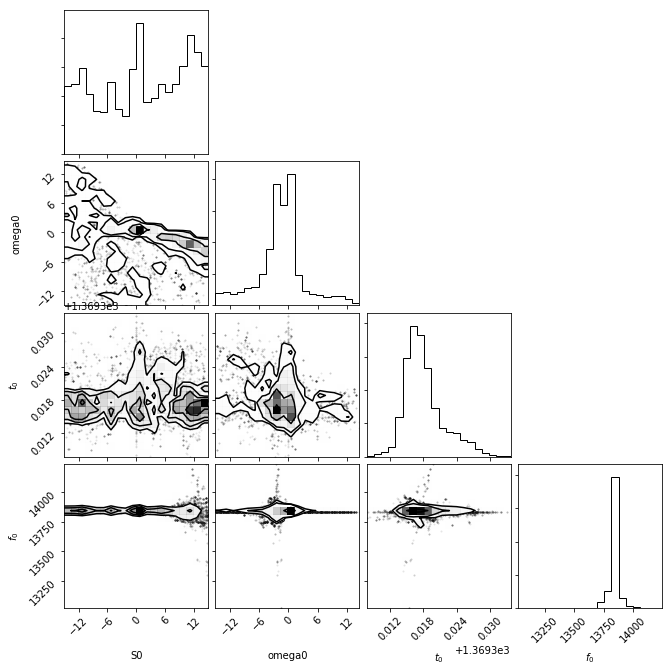

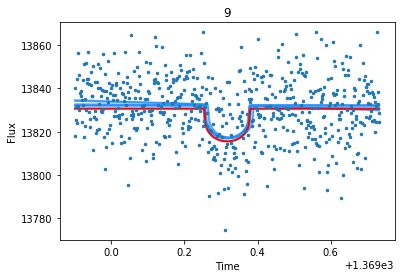

Initial log likelihood: -2379.230135321808


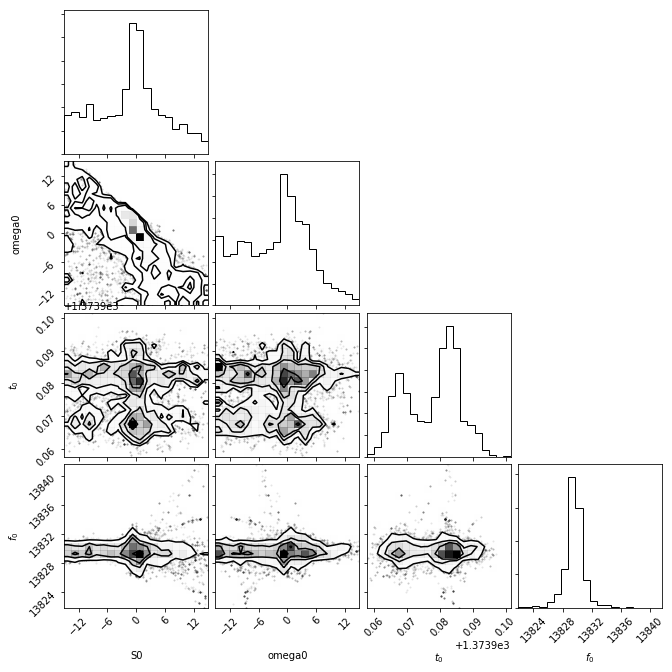

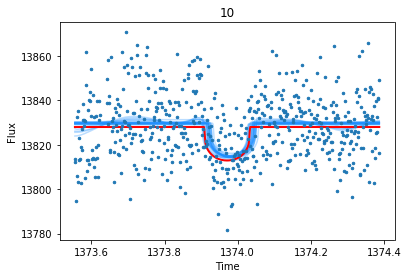

In [10]:
transit_times_b = []


class MeanModel(modeling.Model):
    parameter_names = ("t0", "f0")

    def get_value(self, t):
        params = deepcopy(paramsb)
        params.t0 = self.t0
        m = TransitModel(params, t)
        model = self.f0*m.light_curve(params) 
        return model


for transit in transitsb:    
    x, y, yerr = transit.times.jd, transit.fluxes, np.std(transit.fluxes)
    # A non-periodic component
    Q = 1.0 / np.sqrt(2.0)
    w0 = 3.0
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                           bounds=bounds)
    kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

    mean_model = MeanModel(t0=np.mean(x), f0=np.median(y))
    gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
    gp.compute(x, yerr)  # You always need to call compute once.
    print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
    
    def log_probability(params):
        gp.set_parameter_vector(params)
        lp = gp.log_prior()
        if not np.isfinite(lp):
            return -np.inf
        return gp.log_likelihood(y) + lp
    
    ndim, nwalkers = 4, 10
    
    initp = [np.array([0, 0, transit.times.jd.mean(), np.median(transit.fluxes)]) + 
             np.concatenate([1e-3 * np.random.randn(3), [1*np.random.randn()]]) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=8)
    sampler.run_mcmc(initp, 5000)
    sampler.reset()
    sampler.run_mcmc(initp, 1000)
    
    corner(sampler.flatchain, labels=["S0", "omega0", "$t_0$", "$f_0$"])
    plt.show()
    
    transit_times_b.append([np.median(sampler.flatchain[:, 2]), 
                            np.std(sampler.flatchain[:, 2])])

    m = TransitModel(paramsb, transit.times.jd)
    model = m.light_curve(paramsb)

    for s in sampler.flatchain[np.random.randint(sampler.flatchain.shape[0], size=24)]:
        gp.set_parameter_vector(s)
        mu = gp.predict(y, x, return_cov=False)
        plt.plot(x, mu, color='DodgerBlue', alpha=0.3)
    plt.plot(transit.times.jd, model * np.median(transit.fluxes), lw=2, color='r')    
    transit.plot(plot_kwargs=dict(ms=5, marker='.', lw=0))
        
    plt.show()

    sampler.pool.close()

In [11]:
np.save('transit_times_b.npy', np.vstack(transit_times_b).T)

Initial log likelihood: -2407.9882783150642


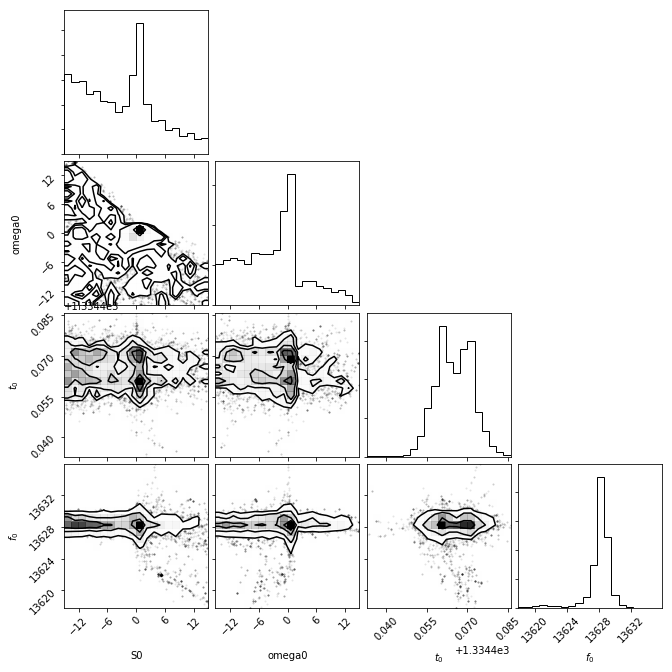

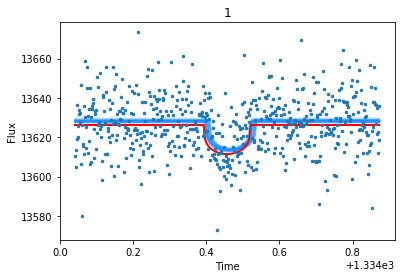

Initial log likelihood: -2466.9208404232595


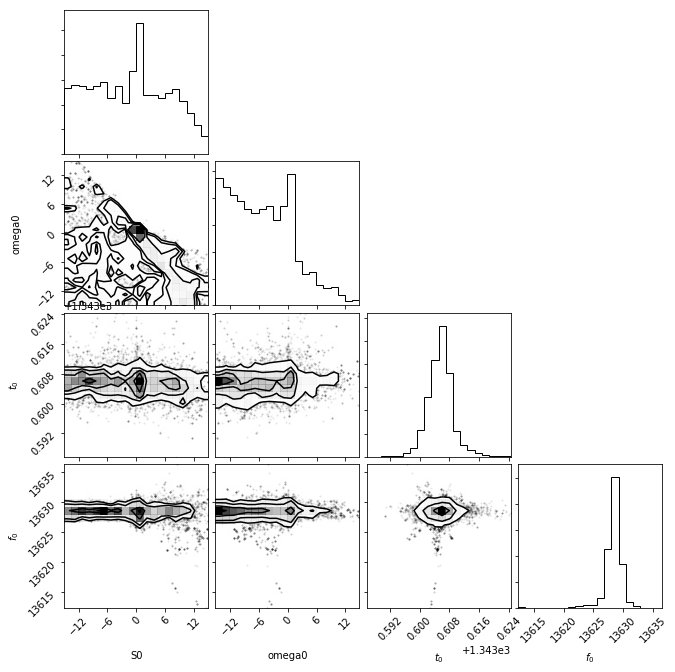

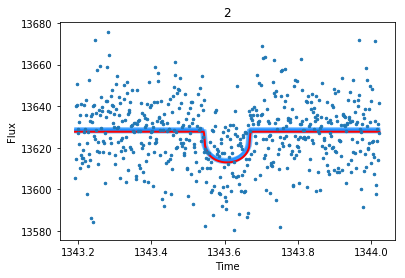

Initial log likelihood: -2476.22172935867


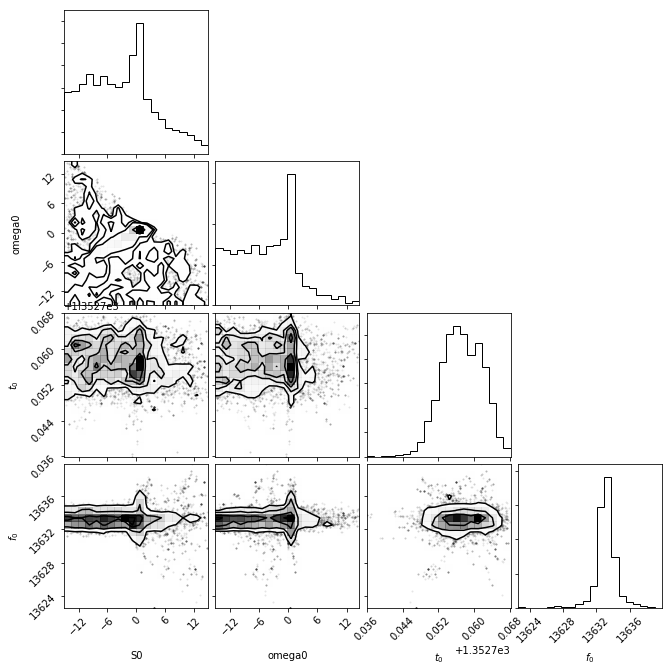

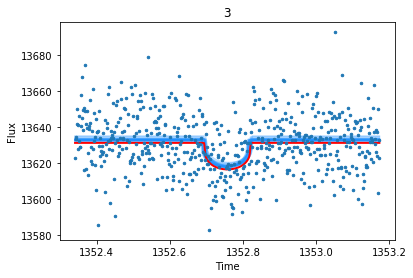

Initial log likelihood: -2368.62772913361


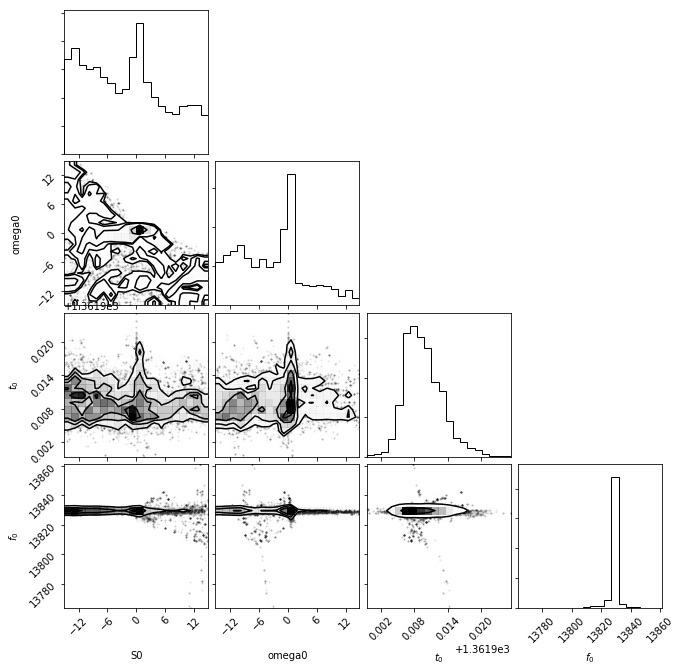

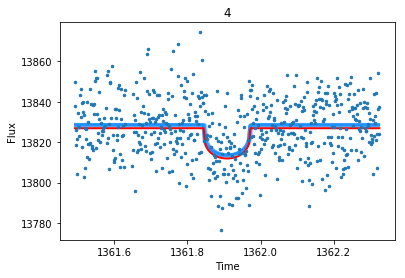

Initial log likelihood: -2373.1262132247944


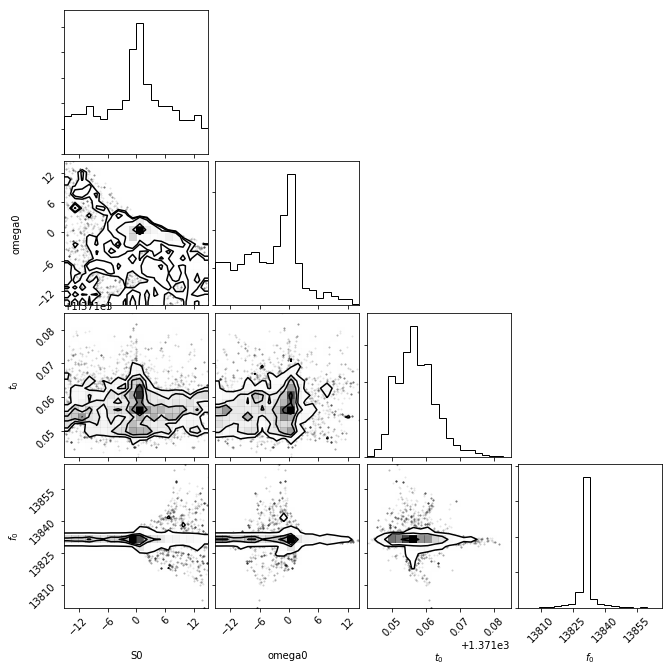

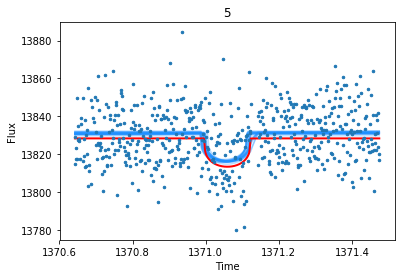

Initial log likelihood: -2423.3523585389044


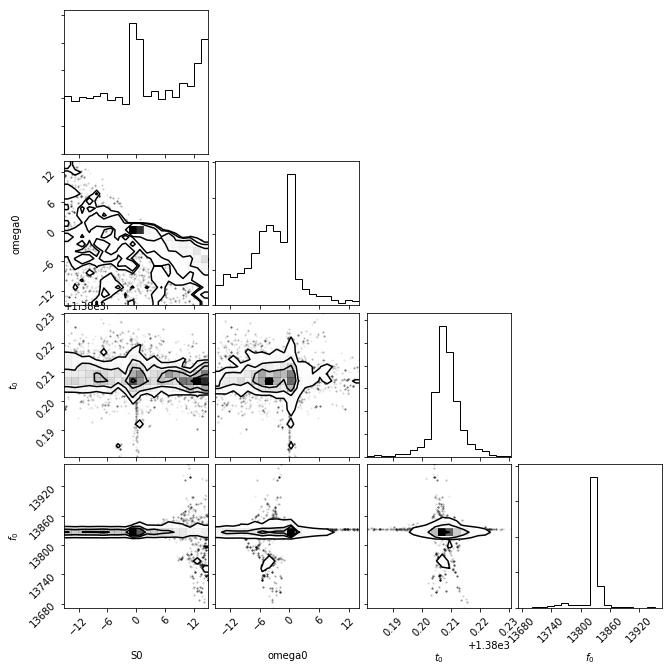

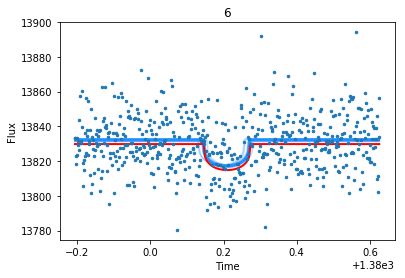

In [12]:
transit_times_c = []


class MeanModel(modeling.Model):
    parameter_names = ("t0", "f0")

    def get_value(self, t):
        params = deepcopy(paramsc)
        params.t0 = self.t0
        m = TransitModel(params, t)
        model = self.f0*m.light_curve(params) 
        return model


for transit in transitsc:    
    x, y, yerr = transit.times.jd, transit.fluxes, np.std(transit.fluxes)
    # A non-periodic component
    Q = 1.0 / np.sqrt(2.0)
    w0 = 3.0
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
    kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                           bounds=bounds)
    kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

    mean_model = MeanModel(t0=np.mean(x), f0=np.median(y))
    gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
    gp.compute(x, yerr)  # You always need to call compute once.
    print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
    
    def log_probability(params):
        gp.set_parameter_vector(params)
        lp = gp.log_prior()
        if not np.isfinite(lp):
            return -np.inf
        return gp.log_likelihood(y) + lp
    
    ndim, nwalkers = 4, 10
    
    initp = [np.array([0, 0, transit.times.jd.mean(), np.median(transit.fluxes)]) + 
             np.concatenate([1e-3 * np.random.randn(3), [1*np.random.randn()]]) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=8)
    sampler.run_mcmc(initp, 5000)
    sampler.reset()
    sampler.run_mcmc(initp, 1000)
    
    corner(sampler.flatchain, labels=["S0", "omega0", "$t_0$", "$f_0$"])
    plt.show()
    
    transit_times_c.append([np.median(sampler.flatchain[:, 2]), 
                            np.std(sampler.flatchain[:, 2])])

    m = TransitModel(paramsb, transit.times.jd)
    model = m.light_curve(paramsc)

    for s in sampler.flatchain[np.random.randint(sampler.flatchain.shape[0], size=24)]:
        gp.set_parameter_vector(s)
        mu = gp.predict(y, x, return_cov=False)
        plt.plot(x, mu, color='DodgerBlue', alpha=0.3)
    plt.plot(transit.times.jd, model * np.median(transit.fluxes), lw=2, color='r')    
    transit.plot(plot_kwargs=dict(ms=5, marker='.', lw=0))
        
    plt.show()

    sampler.pool.close()

In [13]:
np.save('transit_times_c.npy', np.vstack(transit_times_c).T)